In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['OPENBLAS_NUM_THREAD'] = '1'

In [2]:
device = 'cuda'

In [44]:
%run training.ipynb

In [4]:
import math

In [5]:
class MLP(nn.Module):
    def __init__(
        self,
        *,
        d_in: int,
        d_layers: ty.List[int],
        dropout: float,
        d_out: int,
        categories: ty.Optional[ty.List[int]],
        d_embedding: int,
    ) -> None:
        super().__init__()

        if categories is not None:
            d_in += len(categories) * d_embedding
            category_offsets = torch.tensor([0] + categories[:-1]).cumsum(0)
            self.register_buffer('category_offsets', category_offsets)
            self.category_embeddings = nn.Embedding(sum(categories), d_embedding)
            nn.init.kaiming_uniform_(self.category_embeddings.weight, a=math.sqrt(5))
            print(f'{self.category_embeddings.weight.shape=}')

        self.layers = nn.ModuleList(
            [
                nn.Linear(d_layers[i - 1] if i else d_in, x)
                for i, x in enumerate(d_layers)
            ]
        )
        self.dropout = dropout
        self.head = nn.Linear(d_layers[-1] if d_layers else d_in, d_out)

    def forward(self, x_num, x_cat):
        x = []
        if x_num is not None:
            x.append(x_num)
        if x_cat is not None:
            x.append(
                self.category_embeddings(x_cat + self.category_offsets[None]).view(
                    x_cat.size(0), -1
                )
            )
        x = torch.cat(x, dim=-1)

        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)
            if self.dropout:
                x = F.dropout(x, self.dropout, self.training)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

In [14]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 1024,
    'num_epochs' : 150,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_in' : 27,
    'd_layers' : [441, 209, 382],
    'd_out' : 100,
    'dropout' : 0.2697044507316503,
    'categories': None,
    'd_embedding' : None,
}

optimizer_params = {
    'lr' : 0.0005075419386838162,
    'weight_decay' : 0.0004878545209148741
}

catboost_params = {
    'bagging_temperature' : 0.6788373487088936,
    'depth' : 5,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 3.066893023126909,
    'leaf_estimation_iterations' : 10,
    'learning_rate' : 0.04324396670696182,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

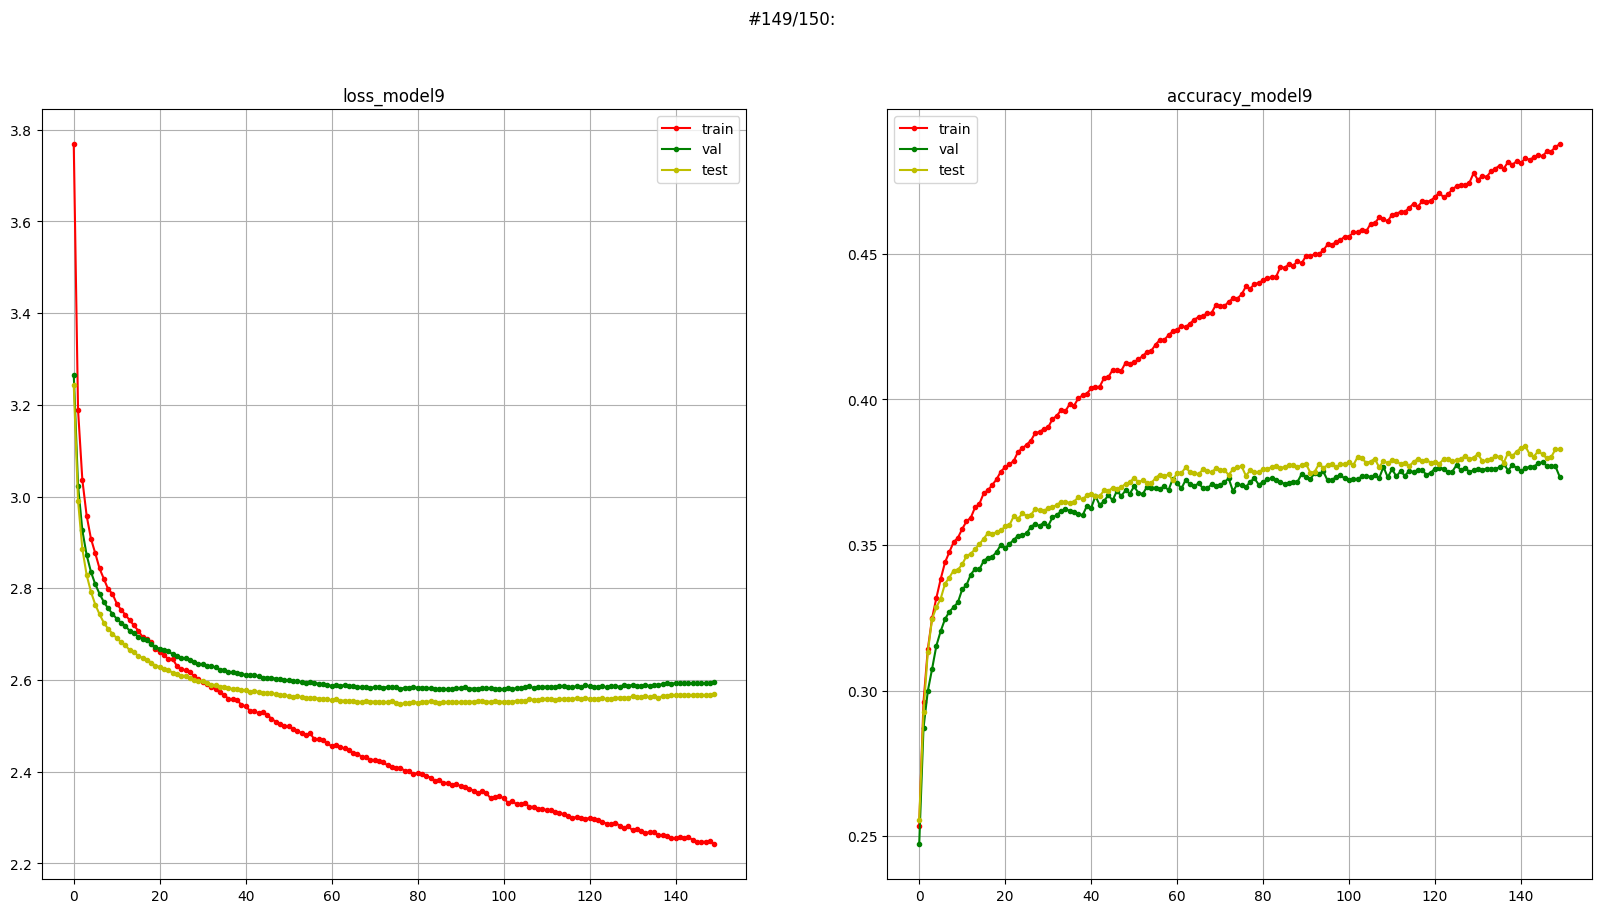

100%|█████████████████████████████████████████| 150/150 [01:45<00:00,  1.42it/s]


0:	learn: 0.1719154	test: 0.1664110	best: 0.1664110 (0)	total: 284ms	remaining: 9m 27s
10:	learn: 0.2085850	test: 0.2016871	best: 0.2017830 (7)	total: 1.94s	remaining: 5m 50s
20:	learn: 0.2452545	test: 0.2358129	best: 0.2358129 (20)	total: 5.01s	remaining: 7m 52s
30:	learn: 0.2609529	test: 0.2488497	best: 0.2488497 (30)	total: 8.2s	remaining: 8m 40s
40:	learn: 0.2727447	test: 0.2618865	best: 0.2618865 (40)	total: 11.5s	remaining: 9m 10s
50:	learn: 0.2842249	test: 0.2707055	best: 0.2707055 (50)	total: 14.9s	remaining: 9m 29s
60:	learn: 0.2952737	test: 0.2781825	best: 0.2781825 (60)	total: 18.4s	remaining: 9m 44s
70:	learn: 0.3039018	test: 0.2829755	best: 0.2829755 (70)	total: 21.9s	remaining: 9m 53s
80:	learn: 0.3126019	test: 0.2926572	best: 0.2926572 (80)	total: 25.4s	remaining: 10m
90:	learn: 0.3221647	test: 0.2996549	best: 0.2996549 (90)	total: 28.8s	remaining: 10m 5s
100:	learn: 0.3297383	test: 0.3031058	best: 0.3031058 (100)	total: 32.4s	remaining: 10m 8s
110:	learn: 0.3369763	test

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.2423066	test: 0.2353336	best: 0.2353336 (0)	total: 115ms	remaining: 3m 50s
10:	learn: 0.3341961	test: 0.3274540	best: 0.3274540 (10)	total: 1.76s	remaining: 5m 17s
20:	learn: 0.3929872	test: 0.3867906	best: 0.3867906 (20)	total: 4.06s	remaining: 6m 22s
30:	learn: 0.4352651	test: 0.4213957	best: 0.4213957 (30)	total: 7.46s	remaining: 7m 53s
40:	learn: 0.4632106	test: 0.4504410	best: 0.4504410 (40)	total: 10.9s	remaining: 8m 40s
50:	learn: 0.4906529	test: 0.4734471	best: 0.4734471 (50)	total: 14.4s	remaining: 9m 9s
60:	learn: 0.5172083	test: 0.4950153	best: 0.4950153 (60)	total: 17.9s	remaining: 9m 28s
70:	learn: 0.5388505	test: 0.5134202	best: 0.5134202 (70)	total: 21.3s	remaining: 9m 39s
80:	learn: 0.5581440	test: 0.5277991	best: 0.5277991 (80)	total: 24.8s	remaining: 9m 47s
90:	learn: 0.5763829	test: 0.5445744	best: 0.5445744 (90)	total: 28.3s	remaining: 9m 54s
100:	learn: 0.5933755	test: 0.5595284	best: 0.5595284 (100)	total: 31.8s	remaining: 9m 58s
110:	learn: 0.6064615	

 20%|████████▊                                   | 1/5 [11:35<46:22, 695.73s/it]

0:	learn: 0.2539066	test: 0.2488497	best: 0.2488497 (0)	total: 112ms	remaining: 3m 44s
10:	learn: 0.3470425	test: 0.3449003	best: 0.3453796 (9)	total: 1.37s	remaining: 4m 7s
20:	learn: 0.3784393	test: 0.3782592	best: 0.3782592 (20)	total: 2.64s	remaining: 4m 9s
30:	learn: 0.4068642	test: 0.4026074	best: 0.4026074 (30)	total: 4.77s	remaining: 5m 3s
40:	learn: 0.4510833	test: 0.4395130	best: 0.4395130 (40)	total: 8.03s	remaining: 6m 23s
50:	learn: 0.4840859	test: 0.4687500	best: 0.4687500 (50)	total: 11.6s	remaining: 7m 21s
60:	learn: 0.5120075	test: 0.4926189	best: 0.4926189 (60)	total: 15.1s	remaining: 8m
70:	learn: 0.5353274	test: 0.5138995	best: 0.5138995 (70)	total: 18.6s	remaining: 8m 24s
80:	learn: 0.5538779	test: 0.5307707	best: 0.5307707 (80)	total: 22.1s	remaining: 8m 44s
90:	learn: 0.5731234	test: 0.5522431	best: 0.5522431 (90)	total: 25.7s	remaining: 8m 58s
100:	learn: 0.5902598	test: 0.5649923	best: 0.5649923 (100)	total: 29.2s	remaining: 9m 9s
110:	learn: 0.6061979	test: 0.

 40%|█████████████████▌                          | 2/5 [23:09<34:43, 694.47s/it]

0:	learn: 0.2485620	test: 0.2437692	best: 0.2437692 (0)	total: 112ms	remaining: 3m 43s
10:	learn: 0.3565094	test: 0.3531442	best: 0.3531442 (10)	total: 1.8s	remaining: 5m 25s
20:	learn: 0.4013997	test: 0.3954179	best: 0.3954179 (20)	total: 4.31s	remaining: 6m 45s
30:	learn: 0.4402262	test: 0.4304064	best: 0.4304064 (30)	total: 7.73s	remaining: 8m 10s
40:	learn: 0.4682677	test: 0.4559049	best: 0.4559049 (40)	total: 11.3s	remaining: 8m 57s
50:	learn: 0.4941041	test: 0.4785276	best: 0.4785276 (50)	total: 14.8s	remaining: 9m 24s
60:	learn: 0.5194612	test: 0.4996166	best: 0.4996166 (60)	total: 18.2s	remaining: 9m 39s
70:	learn: 0.5393059	test: 0.5187883	best: 0.5187883 (70)	total: 21.7s	remaining: 9m 49s
80:	learn: 0.5574969	test: 0.5342216	best: 0.5342216 (80)	total: 25.2s	remaining: 9m 57s
90:	learn: 0.5730515	test: 0.5484087	best: 0.5484087 (90)	total: 28.8s	remaining: 10m 3s
100:	learn: 0.5894929	test: 0.5610621	best: 0.5610621 (100)	total: 32.3s	remaining: 10m 6s
110:	learn: 0.6036574	

 60%|██████████████████████████▍                 | 3/5 [34:46<23:11, 695.60s/it]

0:	learn: 0.2455661	test: 0.2382094	best: 0.2382094 (0)	total: 113ms	remaining: 3m 46s
10:	learn: 0.3200556	test: 0.3160468	best: 0.3160468 (10)	total: 1.23s	remaining: 3m 42s
20:	learn: 0.3594574	test: 0.3594709	best: 0.3594709 (20)	total: 2.67s	remaining: 4m 11s
30:	learn: 0.4099319	test: 0.4079755	best: 0.4079755 (30)	total: 5.41s	remaining: 5m 43s
40:	learn: 0.4443006	test: 0.4352952	best: 0.4352952 (40)	total: 8.88s	remaining: 7m 4s
50:	learn: 0.4730611	test: 0.4582055	best: 0.4582055 (50)	total: 12.4s	remaining: 7m 53s
60:	learn: 0.4992091	test: 0.4793903	best: 0.4793903 (60)	total: 15.9s	remaining: 8m 24s
70:	learn: 0.5219298	test: 0.5002876	best: 0.5002876 (70)	total: 19.4s	remaining: 8m 48s
80:	learn: 0.5429489	test: 0.5171587	best: 0.5171587 (80)	total: 23s	remaining: 9m 4s
90:	learn: 0.5610200	test: 0.5335506	best: 0.5335506 (90)	total: 26.5s	remaining: 9m 16s
100:	learn: 0.5764308	test: 0.5480253	best: 0.5480253 (100)	total: 30.1s	remaining: 9m 25s
110:	learn: 0.5910267	tes

 80%|███████████████████████████████████▏        | 4/5 [46:25<11:36, 696.92s/it]

0:	learn: 0.2551050	test: 0.2500959	best: 0.2500959 (0)	total: 115ms	remaining: 3m 50s
10:	learn: 0.3575161	test: 0.3531442	best: 0.3531442 (10)	total: 1.51s	remaining: 4m 34s
20:	learn: 0.4054741	test: 0.3979103	best: 0.3988689 (19)	total: 4.25s	remaining: 6m 40s
30:	learn: 0.4459544	test: 0.4364456	best: 0.4364456 (30)	total: 7.7s	remaining: 8m 8s
40:	learn: 0.4779743	test: 0.4604103	best: 0.4604103 (40)	total: 11.2s	remaining: 8m 56s
50:	learn: 0.5032116	test: 0.4815951	best: 0.4815951 (50)	total: 14.7s	remaining: 9m 21s
60:	learn: 0.5296472	test: 0.5070936	best: 0.5070936 (60)	total: 18.1s	remaining: 9m 36s
70:	learn: 0.5517688	test: 0.5288535	best: 0.5288535 (70)	total: 21.6s	remaining: 9m 47s
80:	learn: 0.5708465	test: 0.5443827	best: 0.5443827 (80)	total: 25.1s	remaining: 9m 55s
90:	learn: 0.5883185	test: 0.5588574	best: 0.5588574 (90)	total: 28.7s	remaining: 10m 1s
100:	learn: 0.6062458	test: 0.5728528	best: 0.5728528 (100)	total: 32.2s	remaining: 10m 5s
110:	learn: 0.6198111	t

100%|████████████████████████████████████████████| 5/5 [58:03<00:00, 696.71s/it]


0:	learn: 0.2478430	test: 0.2454946	best: 0.2454946 (0)	total: 122ms	remaining: 4m 4s
10:	learn: 0.3212779	test: 0.3182515	best: 0.3182515 (10)	total: 1.38s	remaining: 4m 9s
20:	learn: 0.3888889	test: 0.3882285	best: 0.3882285 (20)	total: 3.11s	remaining: 4m 53s
30:	learn: 0.4269246	test: 0.4183282	best: 0.4183282 (30)	total: 6.56s	remaining: 6m 56s
40:	learn: 0.4615090	test: 0.4496741	best: 0.4496741 (40)	total: 10.2s	remaining: 8m 8s
50:	learn: 0.4915636	test: 0.4772814	best: 0.4772814 (50)	total: 13.9s	remaining: 8m 51s
60:	learn: 0.5213546	test: 0.5021089	best: 0.5021089 (60)	total: 17.5s	remaining: 9m 17s
70:	learn: 0.5419663	test: 0.5241564	best: 0.5241564 (70)	total: 21.2s	remaining: 9m 35s
80:	learn: 0.5633928	test: 0.5437117	best: 0.5437117 (80)	total: 24.8s	remaining: 9m 47s
90:	learn: 0.5814879	test: 0.5570360	best: 0.5570360 (90)	total: 28.5s	remaining: 9m 57s
100:	learn: 0.5973540	test: 0.5694977	best: 0.5694977 (100)	total: 32.1s	remaining: 10m 4s
110:	learn: 0.6129086	te

In [15]:
dataset_folder = 'helena'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder)
results_models_learning = LearnNModels(9, MLP, model_params, optimizer_params, data_model, train_params, metric)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=5, ensemble_size=3)

In [16]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.3836656441717791
distill_0 : 0.3821319018404908 ---------> 0.3789110429447853
model_1_metric : 0.3809049079754601
distill_1 : 0.3821319018404908 ---------> 0.37438650306748467
model_2_metric : 0.3851993865030675
distill_2 : 0.3821319018404908 ---------> 0.3791411042944785
model_3_metric : 0.38588957055214723
distill_3 : 0.3821319018404908 ---------> 0.37829754601226995
model_4_metric : 0.3855061349693252
distill_4 : 0.3821319018404908 ---------> 0.3745398773006135
averaged ensembles accuracy :  0.3777096114519427


In [1]:
import numpy as np
a = np.array([0.3836656441717791, 0.3809049079754601, 0.3851993865030675, 0.38588957055214723, 0.3855061349693252])
b = np.array([0.3789110429447853, 0.37438650306748467, 0.3791411042944785, 0.37829754601226995, 0.3745398773006135])
a.std(), a.mean(), b.std(), b.mean()

(0.0018274074857185945,
 0.38423312883435584,
 0.002134823879115932,
 0.3770552147239264)

In [27]:
# Jannis Parameters
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 150,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_in' : 54,
    'categories' : None,
    'd_out' : 4,
    'dropout' : 0.193104114830125,
    'd_layers' : [ 103, 249 ],
    'd_embedding' : None
}

optimizer_params = {
    'lr' : 0.0004464303067881836,
    'weight_decay' : 0.0001047720882274504
}

catboost_params = {
    'bagging_temperature' : 0.1775789113135668,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.333715101902845,
    'leaf_estimation_iterations' : 3,
    'learning_rate' : 0.04816591530865447,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 1,
    'eval_metric': 'Accuracy'
}

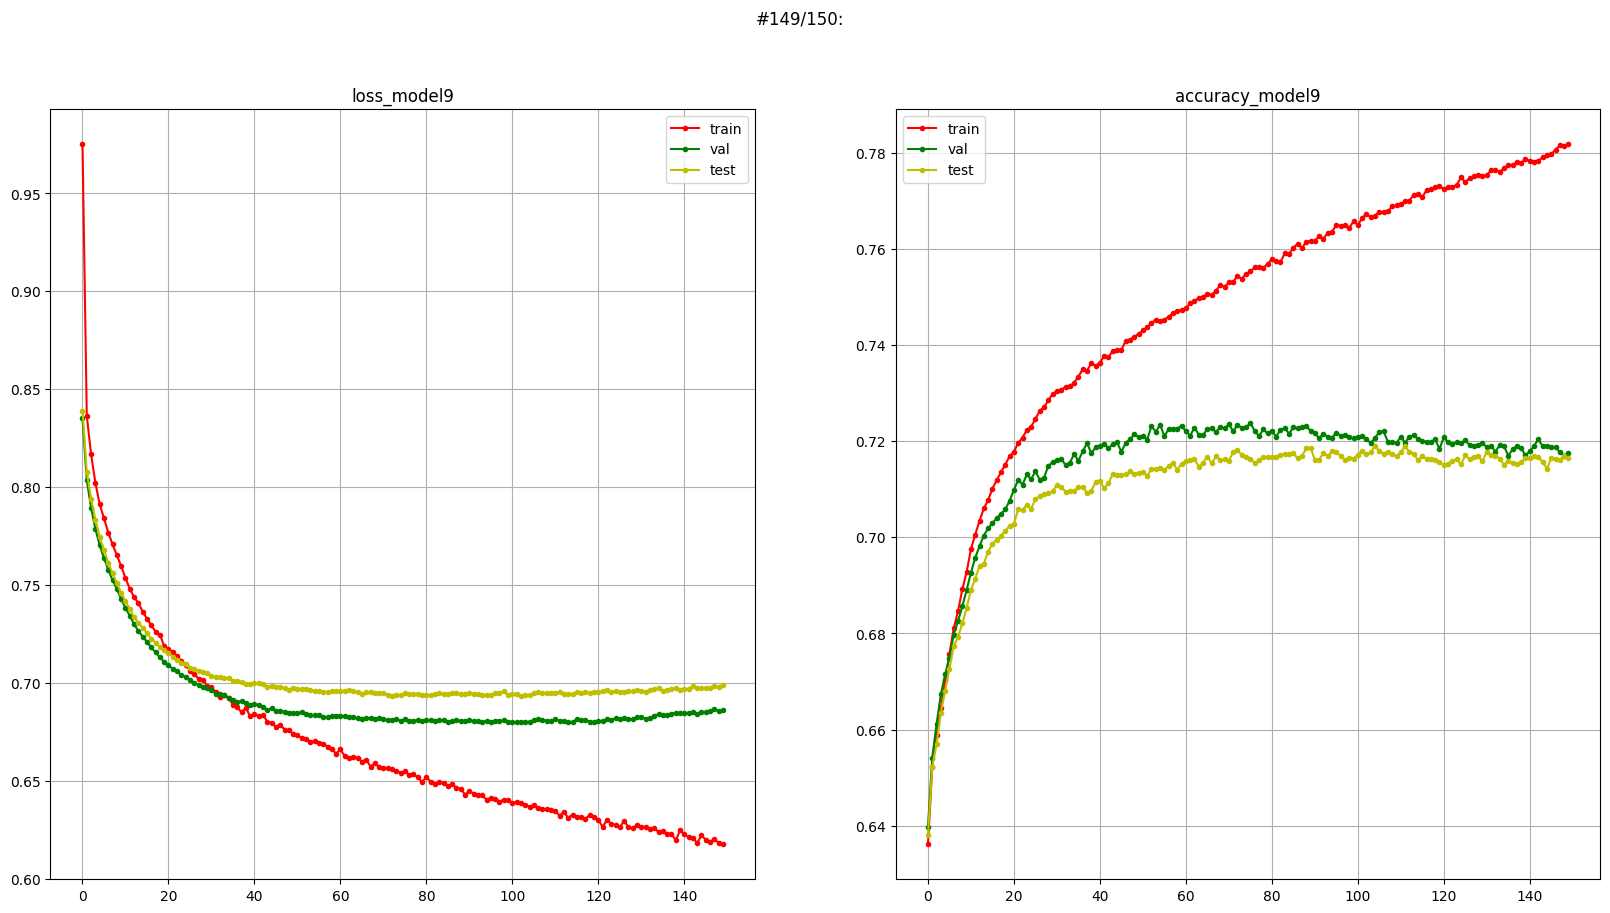

100%|█████████████████████████████████████████| 150/150 [01:44<00:00,  1.44it/s]


0:	learn: 0.6486527	test: 0.6512166	best: 0.6512166 (0)	total: 58.9ms	remaining: 1m 57s
10:	learn: 0.6818504	test: 0.6703986	best: 0.6703986 (10)	total: 504ms	remaining: 1m 31s
20:	learn: 0.6928230	test: 0.6785341	best: 0.6791312 (19)	total: 861ms	remaining: 1m 21s
30:	learn: 0.7022468	test: 0.6848037	best: 0.6848037 (30)	total: 1.23s	remaining: 1m 18s
40:	learn: 0.7106815	test: 0.6921182	best: 0.6921182 (40)	total: 1.59s	remaining: 1m 15s
50:	learn: 0.7180899	test: 0.6965965	best: 0.6965965 (50)	total: 1.93s	remaining: 1m 13s
60:	learn: 0.7238374	test: 0.7012987	best: 0.7012987 (60)	total: 2.27s	remaining: 1m 12s
70:	learn: 0.7283347	test: 0.7059263	best: 0.7059263 (70)	total: 2.59s	remaining: 1m 10s
80:	learn: 0.7329813	test: 0.7080908	best: 0.7080908 (79)	total: 2.91s	remaining: 1m 8s
90:	learn: 0.7373666	test: 0.7093596	best: 0.7103299 (89)	total: 3.23s	remaining: 1m 7s
100:	learn: 0.7416772	test: 0.7113748	best: 0.7114495 (98)	total: 3.57s	remaining: 1m 7s
110:	learn: 0.7455027	te

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7629507	test: 0.7557098	best: 0.7557098 (0)	total: 36.9ms	remaining: 1m 13s
10:	learn: 0.8090244	test: 0.8006419	best: 0.8006419 (10)	total: 396ms	remaining: 1m 11s
20:	learn: 0.8258939	test: 0.8136289	best: 0.8136289 (20)	total: 761ms	remaining: 1m 11s
30:	learn: 0.8377062	test: 0.8243021	best: 0.8243021 (30)	total: 1.12s	remaining: 1m 10s
40:	learn: 0.8482123	test: 0.8343036	best: 0.8343036 (40)	total: 1.47s	remaining: 1m 10s
50:	learn: 0.8562925	test: 0.8401254	best: 0.8401254 (50)	total: 1.82s	remaining: 1m 9s
60:	learn: 0.8642793	test: 0.8488580	best: 0.8488580 (60)	total: 2.17s	remaining: 1m 8s
70:	learn: 0.8718556	test: 0.8519182	best: 0.8519182 (70)	total: 2.51s	remaining: 1m 8s
80:	learn: 0.8773419	test: 0.8560979	best: 0.8560979 (80)	total: 2.85s	remaining: 1m 7s
90:	learn: 0.8829402	test: 0.8592327	best: 0.8593074 (87)	total: 3.2s	remaining: 1m 7s
100:	learn: 0.8866911	test: 0.8625914	best: 0.8625914 (100)	total: 3.53s	remaining: 1m 6s
110:	learn: 0.8897514	test:

 20%|█████████                                    | 1/5 [01:12<04:48, 72.02s/it]

0:	learn: 0.7622042	test: 0.7628751	best: 0.7628751 (0)	total: 36.4ms	remaining: 1m 12s
10:	learn: 0.8036874	test: 0.7985520	best: 0.7985520 (10)	total: 396ms	remaining: 1m 11s
20:	learn: 0.8184108	test: 0.8112405	best: 0.8112405 (20)	total: 759ms	remaining: 1m 11s
30:	learn: 0.8292342	test: 0.8208688	best: 0.8208688 (30)	total: 1.12s	remaining: 1m 11s
40:	learn: 0.8383780	test: 0.8279594	best: 0.8279594 (40)	total: 1.47s	remaining: 1m 10s
50:	learn: 0.8473352	test: 0.8345275	best: 0.8345275 (50)	total: 1.83s	remaining: 1m 9s
60:	learn: 0.8552661	test: 0.8388565	best: 0.8388565 (60)	total: 2.18s	remaining: 1m 9s
70:	learn: 0.8616481	test: 0.8434841	best: 0.8434841 (70)	total: 2.53s	remaining: 1m 8s
80:	learn: 0.8666492	test: 0.8478131	best: 0.8478131 (80)	total: 2.86s	remaining: 1m 7s
90:	learn: 0.8713518	test: 0.8505747	best: 0.8510972 (89)	total: 3.21s	remaining: 1m 7s
100:	learn: 0.8753639	test: 0.8544559	best: 0.8544559 (98)	total: 3.55s	remaining: 1m 6s
110:	learn: 0.8801224	test:

 40%|██████████████████                           | 2/5 [02:23<03:35, 71.89s/it]

0:	learn: 0.7600022	test: 0.7585461	best: 0.7585461 (0)	total: 36.6ms	remaining: 1m 13s
10:	learn: 0.8046204	test: 0.7982535	best: 0.7982535 (10)	total: 398ms	remaining: 1m 11s
20:	learn: 0.8191573	test: 0.8091506	best: 0.8091506 (20)	total: 769ms	remaining: 1m 12s
30:	learn: 0.8301112	test: 0.8186296	best: 0.8186296 (30)	total: 1.12s	remaining: 1m 11s
40:	learn: 0.8414197	test: 0.8295268	best: 0.8296014 (39)	total: 1.48s	remaining: 1m 10s
50:	learn: 0.8506382	test: 0.8359457	best: 0.8363935 (49)	total: 1.84s	remaining: 1m 10s
60:	learn: 0.8568150	test: 0.8404986	best: 0.8404986 (60)	total: 2.18s	remaining: 1m 9s
70:	learn: 0.8638688	test: 0.8466189	best: 0.8467682 (69)	total: 2.52s	remaining: 1m 8s
80:	learn: 0.8699149	test: 0.8516196	best: 0.8516196 (80)	total: 2.86s	remaining: 1m 7s
90:	learn: 0.8747294	test: 0.8564711	best: 0.8564711 (90)	total: 3.2s	remaining: 1m 7s
100:	learn: 0.8789095	test: 0.8593074	best: 0.8593074 (100)	total: 3.54s	remaining: 1m 6s
110:	learn: 0.8835000	test

 60%|███████████████████████████                  | 3/5 [03:36<02:24, 72.09s/it]

0:	learn: 0.7687169	test: 0.7651142	best: 0.7651142 (0)	total: 38.2ms	remaining: 1m 16s
10:	learn: 0.8149399	test: 0.8066129	best: 0.8066129 (10)	total: 410ms	remaining: 1m 14s
20:	learn: 0.8334888	test: 0.8222869	best: 0.8222869 (20)	total: 783ms	remaining: 1m 13s
30:	learn: 0.8437337	test: 0.8313927	best: 0.8313927 (30)	total: 1.14s	remaining: 1m 12s
40:	learn: 0.8536986	test: 0.8393790	best: 0.8393790 (40)	total: 1.5s	remaining: 1m 11s
50:	learn: 0.8633463	test: 0.8463203	best: 0.8466189 (49)	total: 1.85s	remaining: 1m 10s
60:	learn: 0.8709039	test: 0.8547544	best: 0.8547544 (60)	total: 2.21s	remaining: 1m 10s
70:	learn: 0.8775472	test: 0.8591581	best: 0.8591581 (70)	total: 2.55s	remaining: 1m 9s
80:	learn: 0.8830149	test: 0.8631885	best: 0.8631885 (79)	total: 2.91s	remaining: 1m 8s
90:	learn: 0.8876428	test: 0.8664726	best: 0.8669951 (88)	total: 3.25s	remaining: 1m 8s
100:	learn: 0.8915429	test: 0.8708763	best: 0.8708763 (100)	total: 3.59s	remaining: 1m 7s
110:	learn: 0.8953124	tes

 80%|████████████████████████████████████         | 4/5 [04:48<01:12, 72.36s/it]

0:	learn: 0.7711055	test: 0.7699657	best: 0.7699657 (0)	total: 37.5ms	remaining: 1m 14s
10:	learn: 0.8153318	test: 0.8084042	best: 0.8084042 (10)	total: 405ms	remaining: 1m 13s
20:	learn: 0.8322199	test: 0.8207195	best: 0.8219137 (19)	total: 769ms	remaining: 1m 12s
30:	learn: 0.8429686	test: 0.8317659	best: 0.8317659 (30)	total: 1.12s	remaining: 1m 11s
40:	learn: 0.8550982	test: 0.8422153	best: 0.8422153 (40)	total: 1.49s	remaining: 1m 11s
50:	learn: 0.8645032	test: 0.8493805	best: 0.8493805 (50)	total: 1.85s	remaining: 1m 10s
60:	learn: 0.8713891	test: 0.8535602	best: 0.8535602 (60)	total: 2.2s	remaining: 1m 9s
70:	learn: 0.8778831	test: 0.8576653	best: 0.8576653 (69)	total: 2.54s	remaining: 1m 8s
80:	learn: 0.8841718	test: 0.8647559	best: 0.8647559 (80)	total: 2.88s	remaining: 1m 8s
90:	learn: 0.8887997	test: 0.8688610	best: 0.8688610 (90)	total: 3.22s	remaining: 1m 7s
100:	learn: 0.8924386	test: 0.8715480	best: 0.8716973 (98)	total: 3.57s	remaining: 1m 7s
110:	learn: 0.8962081	test:

100%|█████████████████████████████████████████████| 5/5 [06:01<00:00, 72.27s/it]


0:	learn: 0.7666082	test: 0.7667562	best: 0.7667562 (0)	total: 36.7ms	remaining: 1m 13s
10:	learn: 0.8084459	test: 0.8034035	best: 0.8034035 (10)	total: 397ms	remaining: 1m 11s
20:	learn: 0.8266963	test: 0.8175847	best: 0.8175847 (20)	total: 764ms	remaining: 1m 12s
30:	learn: 0.8377622	test: 0.8296014	best: 0.8296014 (30)	total: 1.12s	remaining: 1m 11s
40:	learn: 0.8496119	test: 0.8381102	best: 0.8381102 (40)	total: 1.48s	remaining: 1m 10s
50:	learn: 0.8582892	test: 0.8434841	best: 0.8436334 (49)	total: 1.83s	remaining: 1m 9s
60:	learn: 0.8662014	test: 0.8501269	best: 0.8501269 (59)	total: 2.17s	remaining: 1m 9s
70:	learn: 0.8728820	test: 0.8546798	best: 0.8546798 (70)	total: 2.51s	remaining: 1m 8s
80:	learn: 0.8787788	test: 0.8597552	best: 0.8597552 (80)	total: 2.86s	remaining: 1m 7s
90:	learn: 0.8835000	test: 0.8634871	best: 0.8634871 (90)	total: 3.19s	remaining: 1m 6s
100:	learn: 0.8877361	test: 0.8661741	best: 0.8662487 (99)	total: 3.53s	remaining: 1m 6s
110:	learn: 0.8918228	test:

In [28]:
dataset_folder = 'jannis'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(9, MLP, model_params, optimizer_params, data_model, train_params, metric)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=5, ensemble_size=3)

In [29]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7190541589538425
distill_0 : 0.7210843733205947 ---------> 0.7169045202125753
model_1_metric : 0.7185764614557831
distill_1 : 0.7210843733205947 ---------> 0.7188153102048128
model_2_metric : 0.7170836567743476
distill_2 : 0.7210843733205947 ---------> 0.7176210664596644
model_3_metric : 0.7172627933361199
distill_3 : 0.7210843733205947 ---------> 0.7153520033438825
model_4_metric : 0.7167253836508032
distill_4 : 0.7210843733205947 ---------> 0.7142174717859915
averaged ensembles accuracy :  0.7167054795883839


In [2]:
a = np.array([0.7190541589538425, 0.7185764614557831, 0.7170836567743476, 0.7172627933361199, 0.7167253836508032])
b = np.array([0.7169045202125753, 0.7188153102048128, 0.7176210664596644, 0.7153520033438825, 0.7142174717859915])
a.std(), a.mean(), b.std(), b.mean()

(0.000907153711821011,
 0.7177404908341792,
 0.0016294316976949302,
 0.7165820744013853)

In [30]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 150,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_in' : 28,
    'd_layers' : [ 231, 121 ],
    'categories' : None,
    'd_embedding' : None,
    'd_out' : 2,
    'dropout' : 0.4896848511498748 
}

optimizer_params = {
    'lr' : 0.0007537468376056318,
    'weight_decay' : 0.0
}

catboost_params = {
    'bagging_temperature' : 0.2762051354652655,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 5.6958564294846,
    'leaf_estimation_iterations' : 8,
    'learning_rate' : 0.04558033669158746,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

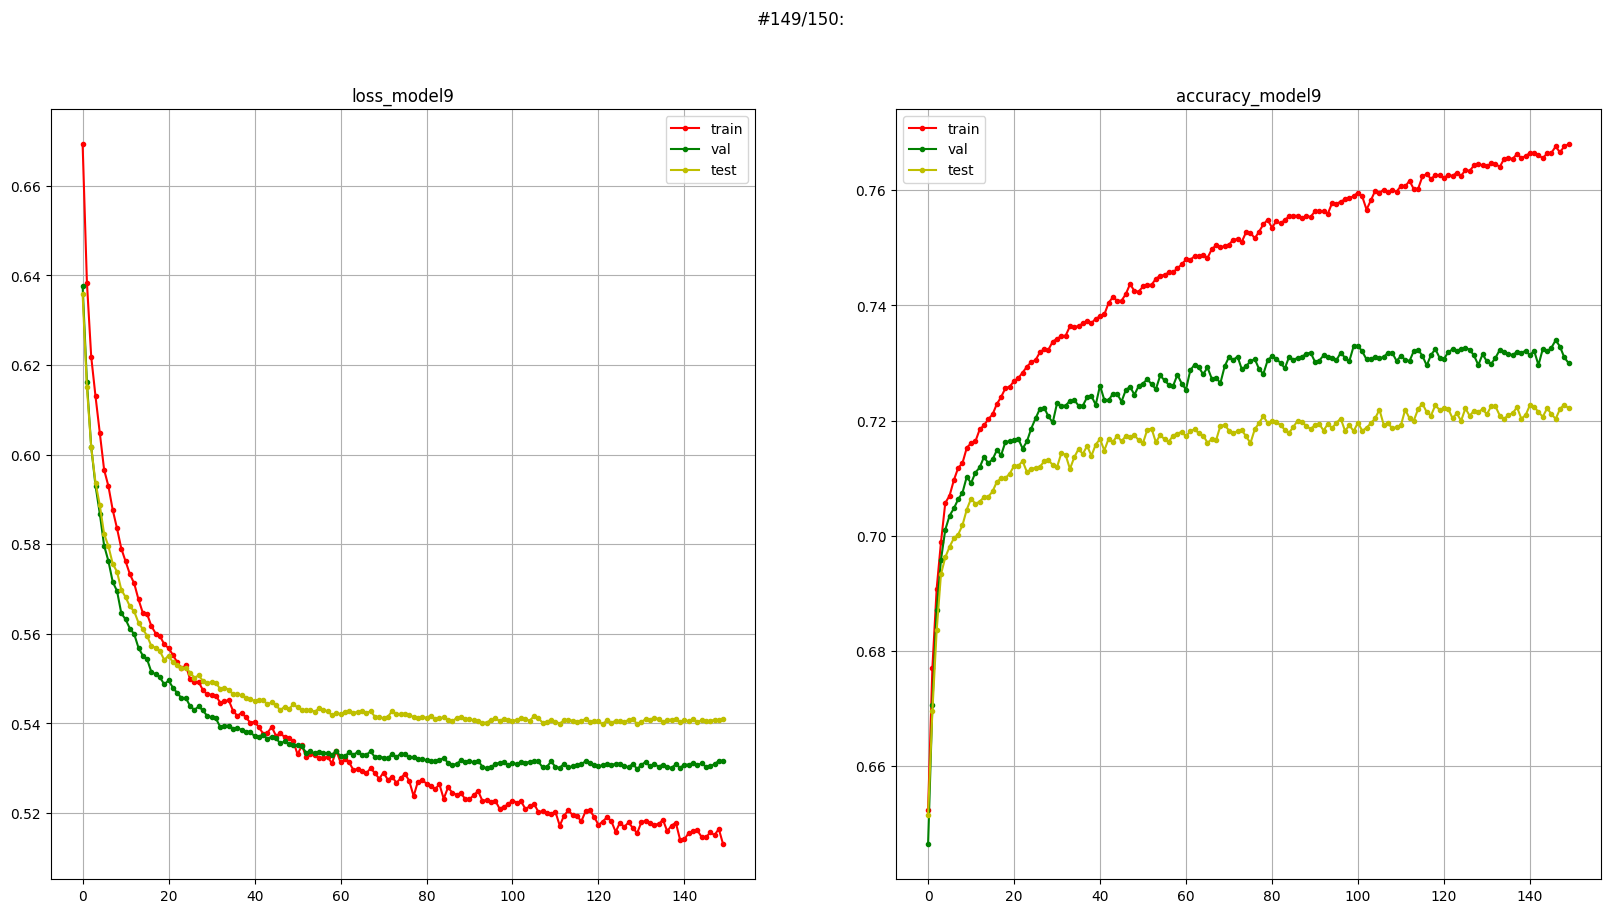

100%|█████████████████████████████████████████| 150/150 [01:49<00:00,  1.37it/s]


0:	learn: 0.6746399	test: 0.6695563	best: 0.6695563 (0)	total: 60.3ms	remaining: 2m
10:	learn: 0.6896832	test: 0.6826237	best: 0.6826237 (10)	total: 188ms	remaining: 34s
20:	learn: 0.7000892	test: 0.6944161	best: 0.6944161 (20)	total: 280ms	remaining: 26.4s
30:	learn: 0.7083121	test: 0.6998980	best: 0.6998980 (30)	total: 370ms	remaining: 23.5s
40:	learn: 0.7131884	test: 0.7018103	best: 0.7018103 (39)	total: 452ms	remaining: 21.6s
50:	learn: 0.7177779	test: 0.7056986	best: 0.7057624 (49)	total: 531ms	remaining: 20.3s
60:	learn: 0.7231642	test: 0.7083758	best: 0.7083758 (60)	total: 611ms	remaining: 19.4s
70:	learn: 0.7276900	test: 0.7113717	best: 0.7113717 (70)	total: 691ms	remaining: 18.8s
80:	learn: 0.7309090	test: 0.7130928	best: 0.7134115 (79)	total: 770ms	remaining: 18.2s
90:	learn: 0.7348770	test: 0.7135390	best: 0.7135390 (90)	total: 850ms	remaining: 17.8s
100:	learn: 0.7371717	test: 0.7132203	best: 0.7141764 (95)	total: 930ms	remaining: 17.5s
110:	learn: 0.7404545	test: 0.7159612

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7841184	test: 0.7779832	best: 0.7779832 (0)	total: 9.69ms	remaining: 19.4s
10:	learn: 0.8125000	test: 0.8090898	best: 0.8090898 (10)	total: 90.5ms	remaining: 16.4s
20:	learn: 0.8279099	test: 0.8238144	best: 0.8238144 (20)	total: 171ms	remaining: 16.2s
30:	learn: 0.8409612	test: 0.8335033	best: 0.8335033 (30)	total: 254ms	remaining: 16.1s
40:	learn: 0.8506980	test: 0.8425548	best: 0.8425548 (40)	total: 337ms	remaining: 16.1s
50:	learn: 0.8577097	test: 0.8502040	best: 0.8502040 (50)	total: 419ms	remaining: 16s
60:	learn: 0.8637653	test: 0.8553672	best: 0.8553672 (60)	total: 502ms	remaining: 16s
70:	learn: 0.8702193	test: 0.8599567	best: 0.8599567 (69)	total: 586ms	remaining: 15.9s
80:	learn: 0.8760836	test: 0.8667772	best: 0.8667772 (80)	total: 671ms	remaining: 15.9s
90:	learn: 0.8805456	test: 0.8704742	best: 0.8704742 (90)	total: 754ms	remaining: 15.8s
100:	learn: 0.8840834	test: 0.8740439	best: 0.8740439 (100)	total: 837ms	remaining: 15.7s
110:	learn: 0.8878123	test: 0.8765

 20%|█████████                                    | 1/5 [00:16<01:07, 16.84s/it]

0:	learn: 0.7805966	test: 0.7758797	best: 0.7758797 (0)	total: 8.96ms	remaining: 17.9s
10:	learn: 0.8133287	test: 0.8089623	best: 0.8089623 (10)	total: 87.5ms	remaining: 15.8s
20:	learn: 0.8297265	test: 0.8245793	best: 0.8248980 (19)	total: 166ms	remaining: 15.7s
30:	learn: 0.8429691	test: 0.8364992	best: 0.8364992 (30)	total: 245ms	remaining: 15.6s
40:	learn: 0.8521481	test: 0.8458057	best: 0.8460607 (39)	total: 325ms	remaining: 15.5s
50:	learn: 0.8615343	test: 0.8547297	best: 0.8547297 (50)	total: 405ms	remaining: 15.5s
60:	learn: 0.8689285	test: 0.8604666	best: 0.8604666 (60)	total: 487ms	remaining: 15.5s
70:	learn: 0.8755896	test: 0.8658848	best: 0.8658848 (70)	total: 569ms	remaining: 15.4s
80:	learn: 0.8814699	test: 0.8715579	best: 0.8715579 (80)	total: 649ms	remaining: 15.4s
90:	learn: 0.8866331	test: 0.8750637	best: 0.8750637 (90)	total: 730ms	remaining: 15.3s
100:	learn: 0.8896290	test: 0.8776772	best: 0.8778047 (98)	total: 812ms	remaining: 15.3s
110:	learn: 0.8928799	test: 0.8

 40%|██████████████████                           | 2/5 [00:33<00:50, 16.79s/it]

0:	learn: 0.7864132	test: 0.7788756	best: 0.7788756 (0)	total: 9.57ms	remaining: 19.1s
10:	learn: 0.8137908	test: 0.8103646	best: 0.8103646 (10)	total: 90ms	remaining: 16.3s
20:	learn: 0.8304118	test: 0.8255354	best: 0.8255354 (20)	total: 171ms	remaining: 16.1s
30:	learn: 0.8416146	test: 0.8343320	best: 0.8343320 (30)	total: 251ms	remaining: 16s
40:	learn: 0.8521959	test: 0.8422998	best: 0.8422998 (39)	total: 332ms	remaining: 15.8s
50:	learn: 0.8609128	test: 0.8519250	best: 0.8519888 (49)	total: 412ms	remaining: 15.8s
60:	learn: 0.8685460	test: 0.8576619	best: 0.8576619 (60)	total: 494ms	remaining: 15.7s
70:	learn: 0.8743626	test: 0.8628251	best: 0.8628251 (70)	total: 575ms	remaining: 15.6s
80:	learn: 0.8796532	test: 0.8676058	best: 0.8676058 (80)	total: 656ms	remaining: 15.5s
90:	learn: 0.8848164	test: 0.8713666	best: 0.8713666 (89)	total: 738ms	remaining: 15.5s
100:	learn: 0.8877645	test: 0.8746813	best: 0.8749363 (99)	total: 820ms	remaining: 15.4s
110:	learn: 0.8916210	test: 0.87774

 60%|███████████████████████████                  | 3/5 [00:50<00:33, 16.84s/it]

0:	learn: 0.7834651	test: 0.7802142	best: 0.7802142 (0)	total: 9.29ms	remaining: 18.6s
10:	learn: 0.8147310	test: 0.8103009	best: 0.8103009 (10)	total: 89.3ms	remaining: 16.2s
20:	learn: 0.8337583	test: 0.8262366	best: 0.8262366 (20)	total: 171ms	remaining: 16.1s
30:	learn: 0.8443715	test: 0.8379653	best: 0.8379653 (30)	total: 251ms	remaining: 16s
40:	learn: 0.8555584	test: 0.8480367	best: 0.8480367 (40)	total: 332ms	remaining: 15.9s
50:	learn: 0.8637016	test: 0.8558134	best: 0.8558134 (50)	total: 413ms	remaining: 15.8s
60:	learn: 0.8695818	test: 0.8611040	best: 0.8611040 (60)	total: 494ms	remaining: 15.7s
70:	learn: 0.8763545	test: 0.8666497	best: 0.8666497 (69)	total: 576ms	remaining: 15.6s
80:	learn: 0.8820117	test: 0.8710479	best: 0.8710479 (80)	total: 658ms	remaining: 15.6s
90:	learn: 0.8870156	test: 0.8754462	best: 0.8754462 (90)	total: 739ms	remaining: 15.5s
100:	learn: 0.8904895	test: 0.8785696	best: 0.8785696 (100)	total: 821ms	remaining: 15.4s
110:	learn: 0.8939795	test: 0.88

 80%|████████████████████████████████████         | 4/5 [01:07<00:16, 16.87s/it]

0:	learn: 0.7904609	test: 0.7832101	best: 0.7832101 (0)	total: 9.38ms	remaining: 18.8s
10:	learn: 0.8161971	test: 0.8074962	best: 0.8074962 (10)	total: 89.3ms	remaining: 16.1s
20:	learn: 0.8302684	test: 0.8205635	best: 0.8205635 (20)	total: 169ms	remaining: 15.9s
30:	learn: 0.8431763	test: 0.8332483	best: 0.8332483 (30)	total: 249ms	remaining: 15.8s
40:	learn: 0.8543473	test: 0.8428098	best: 0.8428098 (40)	total: 331ms	remaining: 15.8s
50:	learn: 0.8622514	test: 0.8501402	best: 0.8501402 (50)	total: 412ms	remaining: 15.7s
60:	learn: 0.8694703	test: 0.8553672	best: 0.8553672 (60)	total: 493ms	remaining: 15.7s
70:	learn: 0.8755737	test: 0.8626976	best: 0.8626976 (70)	total: 575ms	remaining: 15.6s
80:	learn: 0.8808644	test: 0.8680520	best: 0.8680520 (80)	total: 656ms	remaining: 15.5s
90:	learn: 0.8853742	test: 0.8718766	best: 0.8718766 (90)	total: 738ms	remaining: 15.5s
100:	learn: 0.8889916	test: 0.8744901	best: 0.8744901 (100)	total: 820ms	remaining: 15.4s
110:	learn: 0.8926568	test: 0.

100%|█████████████████████████████████████████████| 5/5 [01:24<00:00, 16.87s/it]


0:	learn: 0.7891860	test: 0.7826364	best: 0.7826364 (0)	total: 9.07ms	remaining: 18.1s
10:	learn: 0.8159581	test: 0.8105558	best: 0.8105558 (10)	total: 89.6ms	remaining: 16.2s
20:	learn: 0.8334396	test: 0.8273202	best: 0.8273202 (20)	total: 170ms	remaining: 16s
30:	learn: 0.8455189	test: 0.8386028	best: 0.8386028 (30)	total: 250ms	remaining: 15.9s
40:	learn: 0.8554468	test: 0.8484829	best: 0.8484829 (40)	total: 330ms	remaining: 15.8s
50:	learn: 0.8643230	test: 0.8561321	best: 0.8561321 (50)	total: 411ms	remaining: 15.7s
60:	learn: 0.8719722	test: 0.8637812	best: 0.8637812 (60)	total: 493ms	remaining: 15.7s
70:	learn: 0.8782668	test: 0.8677970	best: 0.8679883 (69)	total: 574ms	remaining: 15.6s
80:	learn: 0.8838443	test: 0.8728965	best: 0.8728965 (80)	total: 655ms	remaining: 15.5s
90:	learn: 0.8882267	test: 0.8758287	best: 0.8758924 (89)	total: 737ms	remaining: 15.5s
100:	learn: 0.8923540	test: 0.8804182	best: 0.8804182 (100)	total: 819ms	remaining: 15.4s
110:	learn: 0.8956368	test: 0.88

In [31]:
dataset_folder = 'higgs_small'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(9, MLP, model_params, optimizer_params, data_model, train_params, metric)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=5, ensemble_size=3)

In [32]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7231514533401325
distill_0 : 0.7250892401835798 ---------> 0.7202447730749617
model_1_metric : 0.7213666496685365
distill_1 : 0.7250892401835798 ---------> 0.7189189189189189
model_2_metric : 0.7215196328403876
distill_2 : 0.7250892401835798 ---------> 0.7211626721060683
model_3_metric : 0.7223865374808771
distill_3 : 0.7250892401835798 ---------> 0.7194288628250892
model_4_metric : 0.7193268740438552
distill_4 : 0.7250892401835798 ---------> 0.7207037225905151
averaged ensembles accuracy :  0.7219955804861465


In [3]:
a = np.array([0.7231514533401325, 0.7213666496685365, 0.7215196328403876, 0.7223865374808771, 0.7193268740438552])
b = np.array([0.7202447730749617, 0.7189189189189189, 0.7211626721060683, 0.7194288628250892, 0.7207037225905151])
a.std(), a.mean(), b.std(), b.mean()

(0.0012838439172700067,
 0.7215502294747578,
 0.0008197259070845617,
 0.7200917899031106)

In [46]:
train_params = {
    'batch_size' : 256,
    'eval_batch_size' : 2048,
    'num_epochs' : 130,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

model_params = {
    'd_in' : 8,
    'categories' : None,
    'd_embedding' : None,
    'd_out' : 1,
    'd_layers' : [ 510, 263, 363 ],
    'dropout' : 0.1973063643675128
}

optimizer_params = {
    'lr' : 0.001304086404538407,
    'weight_decay' : 0.0001516844843295177
}

catboost_params = {
    'bagging_temperature' : 0.004350736313860622,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.157639995907031,
    'leaf_estimation_iterations' : 4,
    'learning_rate' : 0.1021076879315874,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

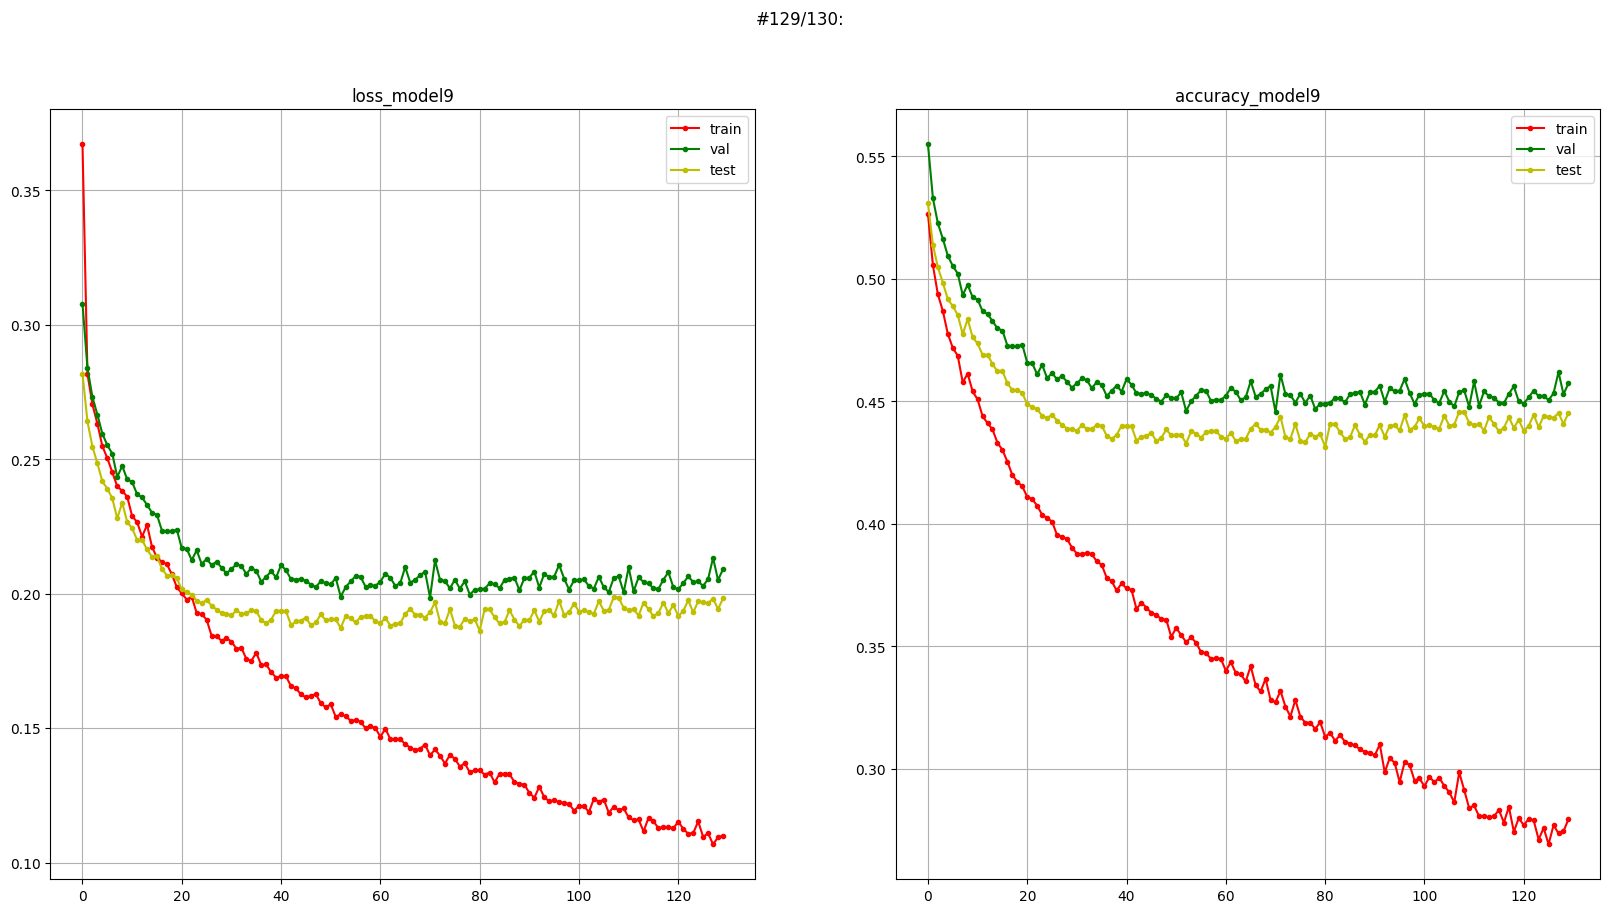

100%|█████████████████████████████████████████| 130/130 [01:17<00:00,  1.68it/s]


0:	learn: 0.9361596	test: 0.9365706	best: 0.9365706 (0)	total: 114ms	remaining: 3m 48s
10:	learn: 0.5903575	test: 0.6043515	best: 0.6043515 (10)	total: 806ms	remaining: 2m 25s
20:	learn: 0.4907550	test: 0.5116647	best: 0.5116647 (20)	total: 1.45s	remaining: 2m 16s
30:	learn: 0.4548279	test: 0.4788678	best: 0.4788678 (30)	total: 2.09s	remaining: 2m 12s
40:	learn: 0.4322337	test: 0.4612566	best: 0.4612566 (40)	total: 2.74s	remaining: 2m 10s
50:	learn: 0.4180322	test: 0.4510834	best: 0.4510834 (50)	total: 3.38s	remaining: 2m 9s
60:	learn: 0.4077928	test: 0.4452423	best: 0.4452423 (60)	total: 3.98s	remaining: 2m 6s
70:	learn: 0.3968504	test: 0.4364781	best: 0.4364781 (70)	total: 4.64s	remaining: 2m 5s
80:	learn: 0.3911905	test: 0.4334863	best: 0.4334863 (80)	total: 5.07s	remaining: 2m
90:	learn: 0.3870045	test: 0.4308548	best: 0.4308548 (90)	total: 5.5s	remaining: 1m 55s
100:	learn: 0.3827532	test: 0.4287226	best: 0.4287226 (100)	total: 5.97s	remaining: 1m 52s
110:	learn: 0.3789732	test: 0

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.8524154	test: 0.8382663	best: 0.8382663 (0)	total: 67.4ms	remaining: 2m 14s
10:	learn: 0.4809294	test: 0.4672214	best: 0.4672214 (10)	total: 730ms	remaining: 2m 11s
20:	learn: 0.3568017	test: 0.3442370	best: 0.3442370 (20)	total: 1.39s	remaining: 2m 11s
30:	learn: 0.3096302	test: 0.2977405	best: 0.2977405 (30)	total: 2.05s	remaining: 2m 10s
40:	learn: 0.2861184	test: 0.2758789	best: 0.2758789 (40)	total: 2.7s	remaining: 2m 9s
50:	learn: 0.2745851	test: 0.2666071	best: 0.2666071 (50)	total: 3.19s	remaining: 2m 1s
60:	learn: 0.2656831	test: 0.2600078	best: 0.2600078 (60)	total: 3.62s	remaining: 1m 55s
70:	learn: 0.2543282	test: 0.2519785	best: 0.2519785 (70)	total: 4.22s	remaining: 1m 54s
80:	learn: 0.2459604	test: 0.2454826	best: 0.2454826 (80)	total: 4.65s	remaining: 1m 50s
90:	learn: 0.2369778	test: 0.2390879	best: 0.2390879 (90)	total: 5.2s	remaining: 1m 49s
100:	learn: 0.2287374	test: 0.2338863	best: 0.2338863 (100)	total: 5.86s	remaining: 1m 50s
110:	learn: 0.2229445	te

 20%|█████████                                    | 1/5 [00:42<02:51, 42.91s/it]

1990:	learn: 0.1547117	test: 0.1990199	best: 0.1990199 (1514)	total: 42.4s	remaining: 192ms
1999:	learn: 0.1547117	test: 0.1990199	best: 0.1990199 (1514)	total: 42.5s	remaining: 0us
bestTest = 0.199019875
bestIteration = 1514
Shrink model to first 1515 iterations.
0:	learn: 0.8305172	test: 0.8194801	best: 0.8194801 (0)	total: 68.1ms	remaining: 2m 16s
10:	learn: 0.4421999	test: 0.4373234	best: 0.4373234 (10)	total: 736ms	remaining: 2m 13s
20:	learn: 0.3134548	test: 0.3124115	best: 0.3124115 (20)	total: 1.4s	remaining: 2m 12s
30:	learn: 0.2648159	test: 0.2664985	best: 0.2664985 (30)	total: 2.06s	remaining: 2m 11s
40:	learn: 0.2401664	test: 0.2446943	best: 0.2446943 (40)	total: 2.73s	remaining: 2m 10s
50:	learn: 0.2303317	test: 0.2366407	best: 0.2366368 (48)	total: 3.11s	remaining: 1m 58s
60:	learn: 0.2172553	test: 0.2260234	best: 0.2260234 (60)	total: 3.66s	remaining: 1m 56s
70:	learn: 0.2072699	test: 0.2172093	best: 0.2172093 (70)	total: 4.27s	remaining: 1m 55s
80:	learn: 0.2034524	test

 40%|██████████████████                           | 2/5 [01:17<01:53, 37.80s/it]

1990:	learn: 0.1405927	test: 0.1747911	best: 0.1747906 (1797)	total: 33.8s	remaining: 153ms
1999:	learn: 0.1405927	test: 0.1747910	best: 0.1747906 (1797)	total: 33.8s	remaining: 0us
bestTest = 0.1747906481
bestIteration = 1797
Shrink model to first 1798 iterations.
0:	learn: 0.8435300	test: 0.8311472	best: 0.8311472 (0)	total: 67.9ms	remaining: 2m 15s
10:	learn: 0.4486891	test: 0.4459992	best: 0.4459992 (10)	total: 736ms	remaining: 2m 13s
20:	learn: 0.3151170	test: 0.3181999	best: 0.3181999 (20)	total: 1.4s	remaining: 2m 11s
30:	learn: 0.2697045	test: 0.2774469	best: 0.2774469 (30)	total: 2.06s	remaining: 2m 11s
40:	learn: 0.2431598	test: 0.2547047	best: 0.2547047 (40)	total: 2.73s	remaining: 2m 10s
50:	learn: 0.2306315	test: 0.2440796	best: 0.2440796 (50)	total: 3.22s	remaining: 2m 3s
60:	learn: 0.2209477	test: 0.2368749	best: 0.2368749 (60)	total: 3.6s	remaining: 1m 54s
70:	learn: 0.2073384	test: 0.2264767	best: 0.2264767 (70)	total: 4.28s	remaining: 1m 56s
80:	learn: 0.1959766	test:

 60%|███████████████████████████                  | 3/5 [01:56<01:16, 38.38s/it]

1999:	learn: 0.1256684	test: 0.1752153	best: 0.1752153 (1999)	total: 38.6s	remaining: 0us
bestTest = 0.1752153013
bestIteration = 1999
0:	learn: 0.8266669	test: 0.8138313	best: 0.8138313 (0)	total: 67.7ms	remaining: 2m 15s
10:	learn: 0.4469444	test: 0.4388876	best: 0.4388876 (10)	total: 734ms	remaining: 2m 12s
20:	learn: 0.3240597	test: 0.3203065	best: 0.3203065 (20)	total: 1.4s	remaining: 2m 11s
30:	learn: 0.2763718	test: 0.2756111	best: 0.2756111 (30)	total: 2.06s	remaining: 2m 10s
40:	learn: 0.2519970	test: 0.2536132	best: 0.2536132 (40)	total: 2.72s	remaining: 2m 10s
50:	learn: 0.2371475	test: 0.2408853	best: 0.2408853 (50)	total: 3.33s	remaining: 2m 7s
60:	learn: 0.2272832	test: 0.2331039	best: 0.2331039 (60)	total: 3.87s	remaining: 2m 3s
70:	learn: 0.2219879	test: 0.2291625	best: 0.2291625 (70)	total: 4.19s	remaining: 1m 53s
80:	learn: 0.2122439	test: 0.2218071	best: 0.2218071 (80)	total: 4.85s	remaining: 1m 55s
90:	learn: 0.2065568	test: 0.2177149	best: 0.2177149 (90)	total: 5.3

 80%|████████████████████████████████████         | 4/5 [02:45<00:42, 42.62s/it]

1999:	learn: 0.1256737	test: 0.1747967	best: 0.1747967 (1999)	total: 48.7s	remaining: 0us
bestTest = 0.1747967466
bestIteration = 1999
0:	learn: 0.8629685	test: 0.8434883	best: 0.8434883 (0)	total: 68.4ms	remaining: 2m 16s
10:	learn: 0.4842060	test: 0.4623966	best: 0.4623966 (10)	total: 736ms	remaining: 2m 13s
20:	learn: 0.3674409	test: 0.3448875	best: 0.3448875 (20)	total: 1.4s	remaining: 2m 11s
30:	learn: 0.3209568	test: 0.2998153	best: 0.2998153 (30)	total: 2.06s	remaining: 2m 10s
40:	learn: 0.2949166	test: 0.2773561	best: 0.2773561 (40)	total: 2.73s	remaining: 2m 10s
50:	learn: 0.2826552	test: 0.2664255	best: 0.2664255 (50)	total: 3.33s	remaining: 2m 7s
60:	learn: 0.2738978	test: 0.2599447	best: 0.2599447 (60)	total: 3.79s	remaining: 2m
70:	learn: 0.2664526	test: 0.2543416	best: 0.2543416 (70)	total: 4.23s	remaining: 1m 54s
80:	learn: 0.2566323	test: 0.2475529	best: 0.2475529 (80)	total: 4.84s	remaining: 1m 54s
90:	learn: 0.2483197	test: 0.2424759	best: 0.2424689 (89)	total: 5.39s	

100%|█████████████████████████████████████████████| 5/5 [03:14<00:00, 38.91s/it]

bestTest = 0.2142559817
bestIteration = 847
Shrink model to first 848 iterations.


0:	learn: 0.8385097	test: 0.8255722	best: 0.8255722 (0)	total: 68.7ms	remaining: 2m 17s
10:	learn: 0.4544098	test: 0.4468600	best: 0.4468600 (10)	total: 739ms	remaining: 2m 13s
20:	learn: 0.3198005	test: 0.3151323	best: 0.3151323 (20)	total: 1.41s	remaining: 2m 12s
30:	learn: 0.2711760	test: 0.2689088	best: 0.2689088 (30)	total: 2.08s	remaining: 2m 11s
40:	learn: 0.2445592	test: 0.2456937	best: 0.2456937 (40)	total: 2.74s	remaining: 2m 10s
50:	learn: 0.2304696	test: 0.2333096	best: 0.2333096 (50)	total: 3.34s	remaining: 2m 7s
60:	learn: 0.2222170	test: 0.2267705	best: 0.2267494 (57)	total: 3.72s	remaining: 1m 58s
70:	learn: 0.2120032	test: 0.2183727	best: 0.2183727 (70)	total: 4.21s	remaining: 1m 54s
80:	learn: 0.2022466	test: 0.2103024	best: 0.2103024 (80)	total: 4.85s	remaining: 1m 54s
90:	learn: 0.1944961	test: 0.2051259	best: 0.2051259 (90)	total: 5.46s	remaining: 1m 54s
100:	learn: 0.1879809	test: 0.2000963	best: 0.2000963 (100)	total: 6.08s	remaining: 1m 54s
110:	learn: 0.1859402

In [50]:
dataset_folder = 'california_housing'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(9, MLP, model_params, optimizer_params, data_model, train_params, metric, regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=5, ensemble_size=3, regression=True, ensemble_N=3)

In [51]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 0.5048448291119024
distill_0 : 0.4485970063141525 ---------> 0.47344139761221377
model_1_metric : 0.5073531234451408
distill_1 : 0.4485970063141525 ---------> 0.49942904078294453
model_2_metric : 0.5073370154149104
distill_2 : 0.4485970063141525 ---------> 0.49468535683447773
model_3_metric : 0.5040391839231997
distill_3 : 0.4485970063141525 ---------> 0.48416575658916144
model_4_metric : 0.5085726624355293
distill_4 : 0.4485970063141525 ---------> 0.47431698531841
averaged ensembles accuracy :  0.4794947967375837


In [4]:
a = np.array([0.5048448291119024, 0.5073531234451408, 0.5073370154149104, 0.5040391839231997, 0.5085726624355293])
b = np.array([0.47344139761221377, 0.49942904078294453, 0.49468535683447773, 0.48416575658916144, 0.47431698531841])
a.std(), a.mean(), b.std(), b.mean()

(0.001702621649007399,
 0.5064293628661366,
 0.010490106738870698,
 0.48520770742744157)

In [41]:
train_params = {
    'batch_size' : 1024,
    'eval_batch_size' : 2048,
    'num_epochs' : 150,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

model_params = {
    'd_in' : 90,
    'categories' : None,
    'd_embedding' : True,  
    'd_out' : 1,
    'd_layers' : [ 748, 809, 597 ],
    'dropout' : 0.3959280449895429
}

optimizer_params = {
    'lr' : 6.574524116695787e-05,
    'weight_decay' : 0.0001695914325686643
}

catboost_params = {
    'bagging_temperature' : 0.8324949854063162,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 1.077941041711693,
    'leaf_estimation_iterations' : 2,
    'learning_rate' : 0.04659912850277395,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

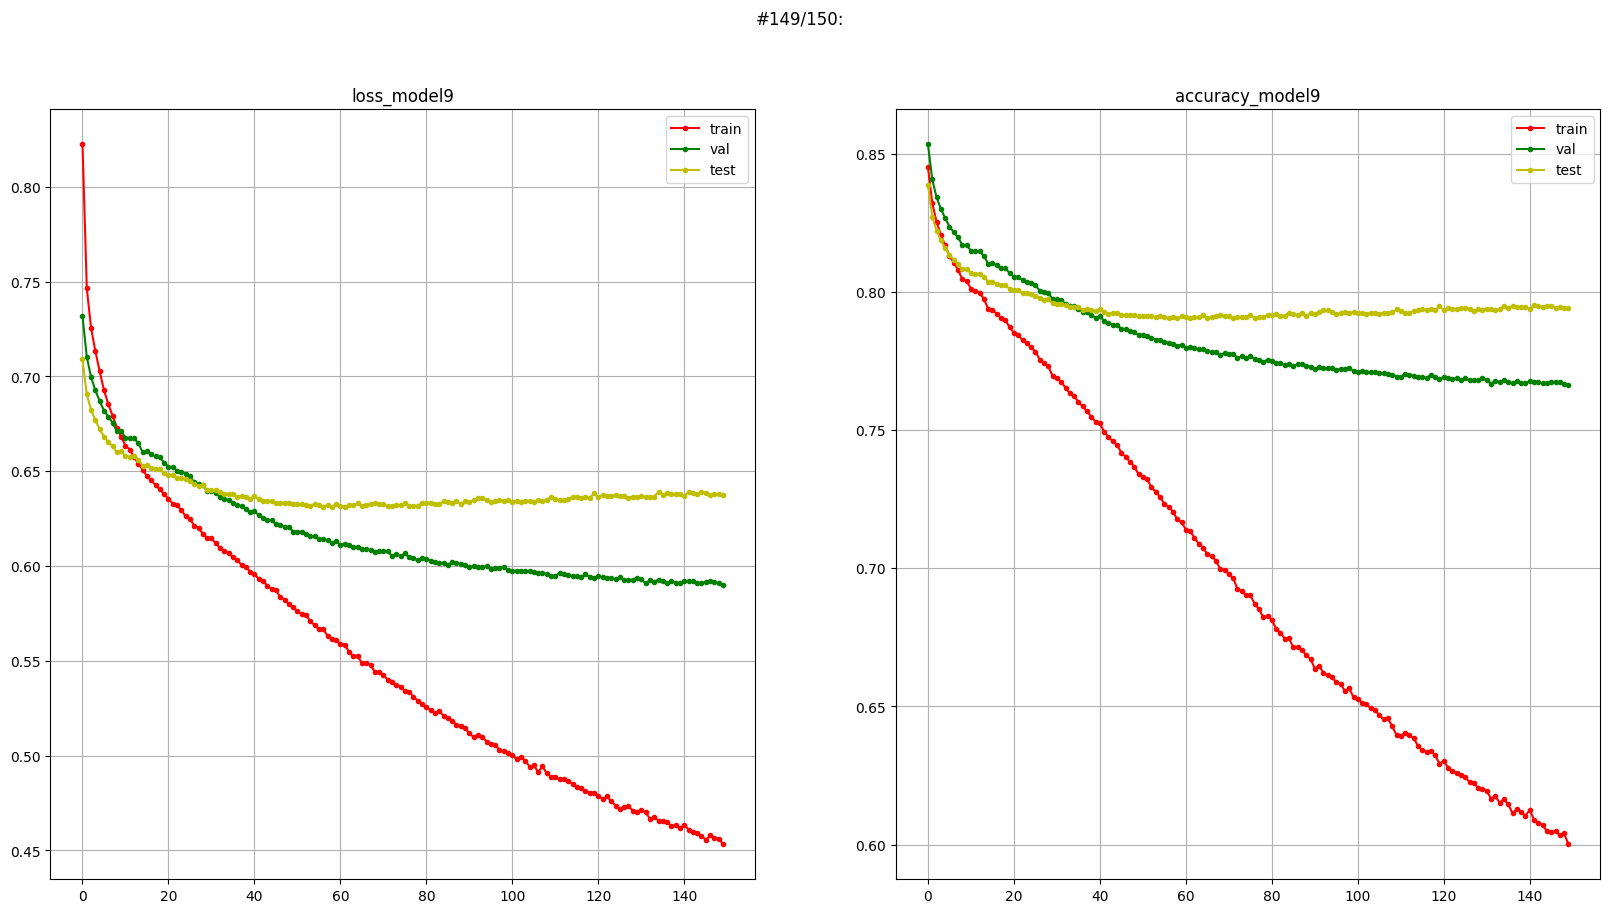

100%|█████████████████████████████████████████| 150/150 [05:29<00:00,  2.20s/it]


0:	learn: 0.9914147	test: 0.9967809	best: 0.9967809 (0)	total: 18ms	remaining: 35.9s
10:	learn: 0.9324685	test: 0.9388348	best: 0.9388348 (10)	total: 187ms	remaining: 33.7s
20:	learn: 0.9001344	test: 0.9072233	best: 0.9072233 (20)	total: 360ms	remaining: 34s
30:	learn: 0.8800481	test: 0.8877585	best: 0.8877585 (30)	total: 534ms	remaining: 33.9s
40:	learn: 0.8667816	test: 0.8750099	best: 0.8750099 (40)	total: 707ms	remaining: 33.8s
50:	learn: 0.8572563	test: 0.8662189	best: 0.8662189 (50)	total: 885ms	remaining: 33.8s
60:	learn: 0.8499228	test: 0.8598097	best: 0.8598097 (60)	total: 1.06s	remaining: 33.7s
70:	learn: 0.8441134	test: 0.8547046	best: 0.8547046 (70)	total: 1.24s	remaining: 33.7s
80:	learn: 0.8388913	test: 0.8506284	best: 0.8506284 (80)	total: 1.42s	remaining: 33.5s
90:	learn: 0.8344994	test: 0.8473707	best: 0.8473707 (90)	total: 1.6s	remaining: 33.5s
100:	learn: 0.8307917	test: 0.8446539	best: 0.8446539 (100)	total: 1.78s	remaining: 33.4s
110:	learn: 0.8271697	test: 0.842223

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6239996	test: 0.5683832	best: 0.5683832 (0)	total: 18.1ms	remaining: 36.1s
10:	learn: 0.5538943	test: 0.4926479	best: 0.4926479 (10)	total: 186ms	remaining: 33.6s
20:	learn: 0.5137280	test: 0.4488306	best: 0.4488306 (20)	total: 362ms	remaining: 34.1s
30:	learn: 0.4886712	test: 0.4213990	best: 0.4213990 (30)	total: 537ms	remaining: 34.1s
40:	learn: 0.4716098	test: 0.4027207	best: 0.4027207 (40)	total: 717ms	remaining: 34.2s
50:	learn: 0.4592874	test: 0.3893382	best: 0.3893382 (50)	total: 896ms	remaining: 34.2s
60:	learn: 0.4496796	test: 0.3790120	best: 0.3790120 (60)	total: 1.08s	remaining: 34.4s
70:	learn: 0.4420461	test: 0.3709111	best: 0.3709111 (70)	total: 1.27s	remaining: 34.4s
80:	learn: 0.4359412	test: 0.3645661	best: 0.3645661 (80)	total: 1.45s	remaining: 34.3s
90:	learn: 0.4305065	test: 0.3592993	best: 0.3592993 (90)	total: 1.63s	remaining: 34.2s
100:	learn: 0.4258553	test: 0.3545515	best: 0.3545515 (100)	total: 1.82s	remaining: 34.2s
110:	learn: 0.4214914	test: 0.3

 20%|█████████                                    | 1/5 [00:38<02:32, 38.20s/it]

0:	learn: 0.6242317	test: 0.5721117	best: 0.5721117 (0)	total: 17.9ms	remaining: 35.8s
10:	learn: 0.5525548	test: 0.4947275	best: 0.4947275 (10)	total: 185ms	remaining: 33.5s
20:	learn: 0.5112782	test: 0.4496696	best: 0.4496696 (20)	total: 355ms	remaining: 33.5s
30:	learn: 0.4853647	test: 0.4212982	best: 0.4212982 (30)	total: 527ms	remaining: 33.5s
40:	learn: 0.4680244	test: 0.4021533	best: 0.4021533 (40)	total: 700ms	remaining: 33.5s
50:	learn: 0.4555559	test: 0.3884490	best: 0.3884490 (50)	total: 878ms	remaining: 33.5s
60:	learn: 0.4459806	test: 0.3780932	best: 0.3780932 (60)	total: 1.05s	remaining: 33.5s
70:	learn: 0.4382979	test: 0.3700306	best: 0.3700306 (70)	total: 1.24s	remaining: 33.7s
80:	learn: 0.4318290	test: 0.3632541	best: 0.3632541 (80)	total: 1.42s	remaining: 33.7s
90:	learn: 0.4264814	test: 0.3579718	best: 0.3579718 (90)	total: 1.61s	remaining: 33.7s
100:	learn: 0.4218535	test: 0.3533069	best: 0.3533069 (100)	total: 1.78s	remaining: 33.5s
110:	learn: 0.4174504	test: 0.3

 40%|██████████████████                           | 2/5 [01:16<01:54, 38.06s/it]

0:	learn: 0.6229278	test: 0.5663399	best: 0.5663399 (0)	total: 18.1ms	remaining: 36.3s
10:	learn: 0.5535223	test: 0.4910067	best: 0.4910067 (10)	total: 187ms	remaining: 33.9s
20:	learn: 0.5140238	test: 0.4477460	best: 0.4477460 (20)	total: 369ms	remaining: 34.8s
30:	learn: 0.4894034	test: 0.4206233	best: 0.4206233 (30)	total: 546ms	remaining: 34.7s
40:	learn: 0.4726851	test: 0.4022182	best: 0.4022182 (40)	total: 727ms	remaining: 34.7s
50:	learn: 0.4604259	test: 0.3887304	best: 0.3887304 (50)	total: 905ms	remaining: 34.6s
60:	learn: 0.4510273	test: 0.3786949	best: 0.3786949 (60)	total: 1.09s	remaining: 34.6s
70:	learn: 0.4435899	test: 0.3708609	best: 0.3708609 (70)	total: 1.27s	remaining: 34.5s
80:	learn: 0.4370998	test: 0.3641938	best: 0.3641938 (80)	total: 1.46s	remaining: 34.5s
90:	learn: 0.4317966	test: 0.3587069	best: 0.3587069 (90)	total: 1.64s	remaining: 34.4s
100:	learn: 0.4271513	test: 0.3541002	best: 0.3541002 (100)	total: 1.82s	remaining: 34.3s
110:	learn: 0.4230399	test: 0.3

 60%|███████████████████████████                  | 3/5 [01:54<01:15, 37.98s/it]

0:	learn: 0.6192007	test: 0.5685131	best: 0.5685131 (0)	total: 17.9ms	remaining: 35.7s
10:	learn: 0.5474774	test: 0.4915492	best: 0.4915492 (10)	total: 185ms	remaining: 33.5s
20:	learn: 0.5064313	test: 0.4471263	best: 0.4471263 (20)	total: 356ms	remaining: 33.6s
30:	learn: 0.4806873	test: 0.4192235	best: 0.4192235 (30)	total: 534ms	remaining: 33.9s
40:	learn: 0.4632335	test: 0.4002410	best: 0.4002410 (40)	total: 711ms	remaining: 34s
50:	learn: 0.4505706	test: 0.3864082	best: 0.3864082 (50)	total: 890ms	remaining: 34s
60:	learn: 0.4409128	test: 0.3761241	best: 0.3761241 (60)	total: 1.07s	remaining: 34.1s
70:	learn: 0.4332687	test: 0.3679276	best: 0.3679276 (70)	total: 1.26s	remaining: 34.2s
80:	learn: 0.4267386	test: 0.3610756	best: 0.3610756 (80)	total: 1.44s	remaining: 34.1s
90:	learn: 0.4211717	test: 0.3555160	best: 0.3555160 (90)	total: 1.62s	remaining: 34s
100:	learn: 0.4163853	test: 0.3506720	best: 0.3506720 (100)	total: 1.8s	remaining: 33.9s
110:	learn: 0.4121775	test: 0.3467423	

 80%|████████████████████████████████████         | 4/5 [02:31<00:37, 37.90s/it]

0:	learn: 0.6436077	test: 0.5901576	best: 0.5901576 (0)	total: 18ms	remaining: 36s
10:	learn: 0.5705419	test: 0.5116047	best: 0.5116047 (10)	total: 187ms	remaining: 33.8s
20:	learn: 0.5289365	test: 0.4665643	best: 0.4665643 (20)	total: 358ms	remaining: 33.8s
30:	learn: 0.5023740	test: 0.4376113	best: 0.4376113 (30)	total: 536ms	remaining: 34.1s
40:	learn: 0.4847513	test: 0.4182974	best: 0.4182974 (40)	total: 714ms	remaining: 34.1s
50:	learn: 0.4717995	test: 0.4042275	best: 0.4042275 (50)	total: 890ms	remaining: 34s
60:	learn: 0.4618460	test: 0.3936365	best: 0.3936365 (60)	total: 1.07s	remaining: 34s
70:	learn: 0.4538575	test: 0.3851808	best: 0.3851808 (70)	total: 1.26s	remaining: 34.1s
80:	learn: 0.4470305	test: 0.3782041	best: 0.3782041 (80)	total: 1.44s	remaining: 34.1s
90:	learn: 0.4414480	test: 0.3724754	best: 0.3724754 (90)	total: 1.63s	remaining: 34.1s
100:	learn: 0.4362992	test: 0.3675063	best: 0.3675063 (100)	total: 1.81s	remaining: 34.1s
110:	learn: 0.4319120	test: 0.3634104	b

100%|█████████████████████████████████████████████| 5/5 [03:09<00:00, 37.95s/it]


0:	learn: 0.6158826	test: 0.5572007	best: 0.5572007 (0)	total: 17.8ms	remaining: 35.6s
10:	learn: 0.5447219	test: 0.4794106	best: 0.4794106 (10)	total: 185ms	remaining: 33.4s
20:	learn: 0.5036408	test: 0.4338766	best: 0.4338766 (20)	total: 358ms	remaining: 33.7s
30:	learn: 0.4778351	test: 0.4052234	best: 0.4052234 (30)	total: 535ms	remaining: 34s
40:	learn: 0.4604347	test: 0.3856067	best: 0.3856067 (40)	total: 709ms	remaining: 33.9s
50:	learn: 0.4478332	test: 0.3714599	best: 0.3714599 (50)	total: 888ms	remaining: 33.9s
60:	learn: 0.4382153	test: 0.3607501	best: 0.3607501 (60)	total: 1.07s	remaining: 33.9s
70:	learn: 0.4306413	test: 0.3524643	best: 0.3524643 (70)	total: 1.25s	remaining: 34s
80:	learn: 0.4239413	test: 0.3454384	best: 0.3454384 (80)	total: 1.43s	remaining: 33.9s
90:	learn: 0.4183012	test: 0.3396082	best: 0.3396082 (90)	total: 1.61s	remaining: 33.8s
100:	learn: 0.4134253	test: 0.3345708	best: 0.3345708 (100)	total: 1.79s	remaining: 33.7s
110:	learn: 0.4093081	test: 0.33056

In [42]:
dataset_folder = 'year'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(9, MLP, model_params, optimizer_params, data_model, train_params, metric, regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=5, ensemble_size=3, regression=True)

In [43]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 8.863516666983587
distill_0 : 8.886524300635156 ---------> 8.909664124529018
model_1_metric : 8.856292863462416
distill_1 : 8.886524300635156 ---------> 8.90503859865171
model_2_metric : 8.858708282719434
distill_2 : 8.886524300635156 ---------> 8.911899831611708
model_3_metric : 8.872517491249006
distill_3 : 8.886524300635156 ---------> 8.90571921178746
model_4_metric : 8.857080127022018
distill_4 : 8.886524300635156 ---------> 8.894309673270783
averaged ensembles accuracy :  8.900030552154675


In [5]:
a = np.array([8.863516666983587, 8.856292863462416, 8.858708282719434, 8.872517491249006, 8.857080127022018])
b = np.array([8.909664124529018, 8.90503859865171, 8.911899831611708, 8.90571921178746, 8.894309673270783])
a.std(), a.mean(), b.std(), b.mean()

(0.0059969916026483385,
 8.861623086287292,
 0.006060218737362101,
 8.905326287970135)

In [59]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 100,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

model_params = {
    'd_in' : 128,
    'categories' : None,
    'd_embedding' : True,
    'd_out' : 1000,
    'd_layers' : [ 415, 499 ],
    'dropout' : 0.1509950004266268
}

optimizer_params = {
    'lr' : 0.0002161505605899536,
    'weight_decay' : 0.0
}

catboost_params = {
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

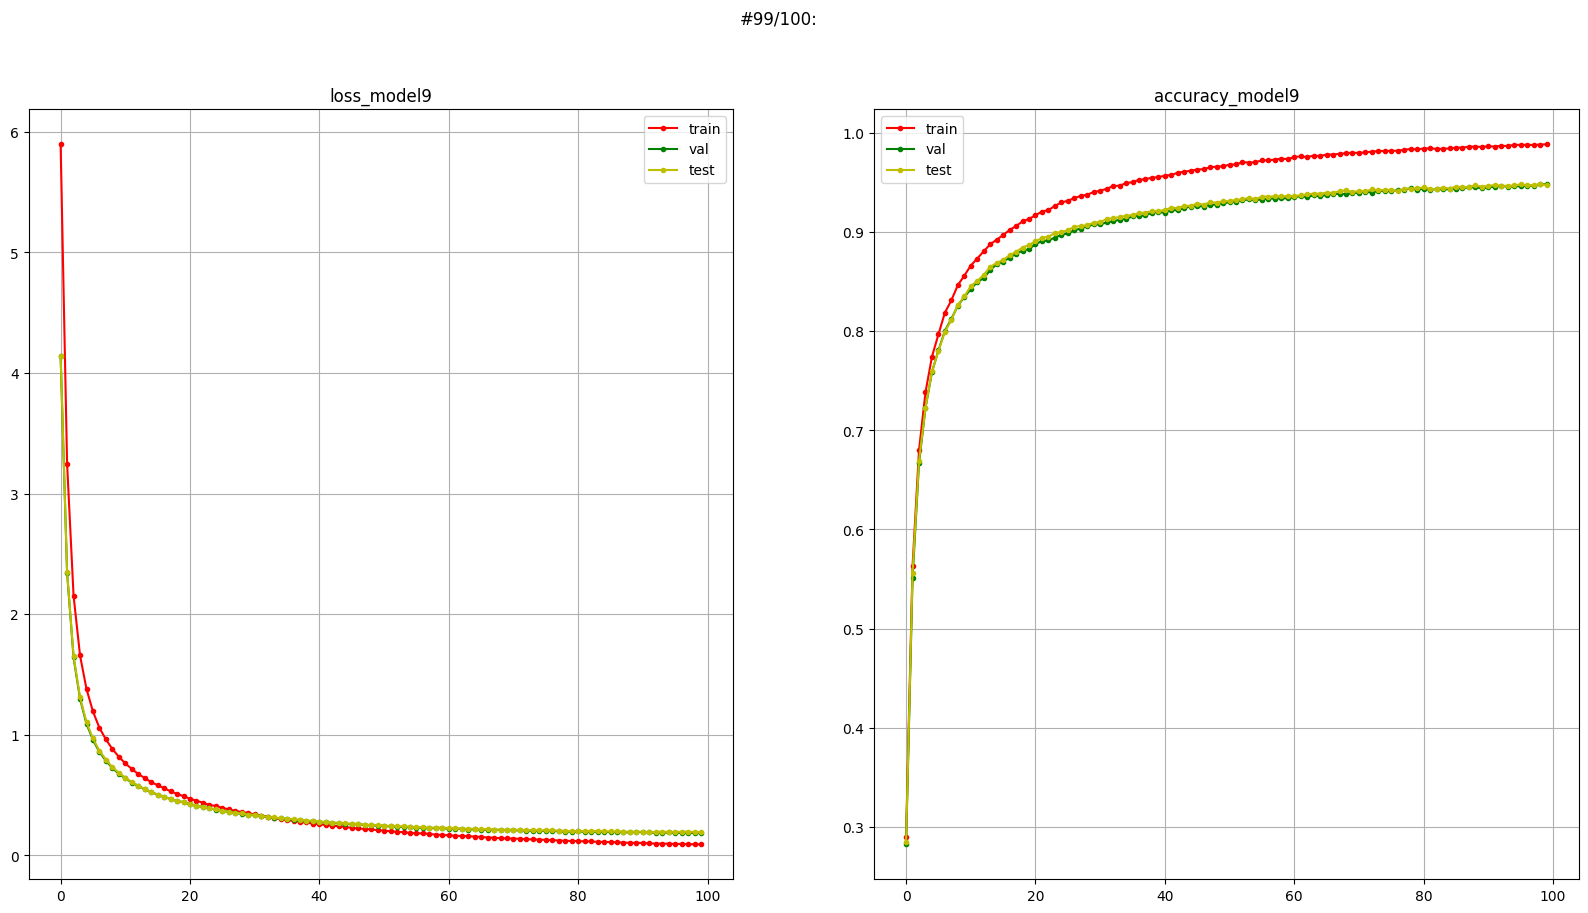

100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Learning rate set to 0.119146
0:	learn: 0.0494792	test: 0.0494792	best: 0.0494792 (0)	total: 7.7s	remaining: 4h 16m 37s
10:	learn: 0.5054253	test: 0.4928241	best: 0.4928241 (10)	total: 1m 18s	remaining: 3h 55m 19s
20:	learn: 0.6959201	test: 0.6759838	best: 0.6759838 (20)	total: 2m 30s	remaining: 3h 56m 18s
30:	learn: 0.7710648	test: 0.7495370	best: 0.7495370 (30)	total: 3m 44s	remaining: 3h 57m 34s
40:	learn: 0.8131366	test: 0.7893519	best: 0.7893519 (40)	total: 5m 1s	remaining: 3h 59m 43s
50:	learn: 0.8368200	test: 0.8118634	best: 0.8118634 (50)	total: 6m 14s	remaining: 3h 58m 26s
60:	learn: 0.8550203	test: 0.8276620	best: 0.8276620 (60)	total: 7m 25s	remaining: 3h 56m 2s
70:	learn: 0.8679687	test: 0.8390625	best: 0.8390625 (70)	total: 8m 33s	remaining: 3h 52m 34s
80:	learn: 0.8780961	test: 0.8491898	best: 0.8491898 (80)	total: 9m 40s	remaining: 3h 49m 23s
90:	learn: 0.8881655	test: 0.8570023	best: 0.8570023 (90)	total: 10m 48s	remaining: 3h 46m 39s
100:	learn: 0.8977720	test: 0.86469

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Learning rate set to 0.119146
0:	learn: 0.0282263	test: 0.0282407	best: 0.0282407 (0)	total: 6.96s	remaining: 3h 52m
10:	learn: 0.5274595	test: 0.5105324	best: 0.5105324 (10)	total: 1m 17s	remaining: 3h 52m 12s
20:	learn: 0.7222801	test: 0.7015625	best: 0.7015625 (20)	total: 2m 30s	remaining: 3h 55m 50s
30:	learn: 0.7990307	test: 0.7759838	best: 0.7759838 (30)	total: 3m 44s	remaining: 3h 57m 40s
40:	learn: 0.8338252	test: 0.8106481	best: 0.8106481 (40)	total: 4m 59s	remaining: 3h 58m 35s
50:	learn: 0.8524740	test: 0.8289931	best: 0.8289931 (50)	total: 6m 10s	remaining: 3h 56m 15s
60:	learn: 0.8688947	test: 0.8441551	best: 0.8441551 (60)	total: 7m 23s	remaining: 3h 54m 55s
70:	learn: 0.8814959	test: 0.8542824	best: 0.8542824 (69)	total: 8m 33s	remaining: 3h 52m 34s
80:	learn: 0.8913628	test: 0.8657986	best: 0.8657986 (80)	total: 9m 44s	remaining: 3h 50m 48s
90:	learn: 0.9007668	test: 0.8729745	best: 0.8729745 (90)	total: 10m 55s	remaining: 3h 49m 8s
100:	learn: 0.9076678	test: 0.8795718

100%|████████████████████████████████████████| 1/1 [3:48:38<00:00, 13718.20s/it]


Learning rate set to 0.119146
0:	learn: 0.0282263	test: 0.0287037	best: 0.0287037 (0)	total: 6.71s	remaining: 3h 43m 24s
10:	learn: 0.4716146	test: 0.4508102	best: 0.4508102 (10)	total: 1m 14s	remaining: 3h 45m 35s
20:	learn: 0.7175637	test: 0.7006366	best: 0.7006366 (20)	total: 2m 26s	remaining: 3h 50m 39s
30:	learn: 0.7950955	test: 0.7766204	best: 0.7766204 (30)	total: 3m 39s	remaining: 3h 52m 42s
40:	learn: 0.8313079	test: 0.8104745	best: 0.8104745 (40)	total: 4m 52s	remaining: 3h 52m 39s
50:	learn: 0.8541377	test: 0.8318866	best: 0.8318866 (50)	total: 6m 2s	remaining: 3h 51m 6s
60:	learn: 0.8689236	test: 0.8439815	best: 0.8439815 (60)	total: 7m 14s	remaining: 3h 50m 3s
70:	learn: 0.8831887	test: 0.8568866	best: 0.8568866 (70)	total: 8m 24s	remaining: 3h 48m 17s
80:	learn: 0.8922454	test: 0.8658565	best: 0.8658565 (80)	total: 9m 33s	remaining: 3h 46m 17s
90:	learn: 0.9015480	test: 0.8729745	best: 0.8729745 (90)	total: 10m 43s	remaining: 3h 44m 51s
100:	learn: 0.9088976	test: 0.87800

In [60]:
dataset_folder = 'aloi'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='standard')
results_models_learning = LearnNModels(9, MLP, model_params, optimizer_params, data_model, train_params, metric)
gc.collect()
torch.cuda.empty_cache()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=1, ensemble_size=3, ensemble_N=1)

In [61]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.9491666666666667
distill_0 : 0.9452777777777778 ---------> 0.9483796296296296
averaged ensembles accuracy :  0.94625
